<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Collaborative Filtering based Recommender System using K Nearest Neighbor**


Estimated time needed: **60** minutes


Collaborative filtering is probably the most commonly used recommendation algorithm, there are two main types of methods: 
 - **User-based** collaborative filtering is based on the user similarity or neighborhood
 - **Item-based** collaborative filtering is based on similarity among items


They both work similarly, let's briefly explain how user-based collaborative filtering works.


User-based collaborative filtering looks for users who are similar. This is very similar to the user clustering method done previously; where we employed explicit user profiles to calculate user similarity. However, the user profiles may not be available, so how can we determine if two users are similar?


#### User-item interaction matrix 


For most collaborative filtering-based recommender systems, the main dataset format is a 2-D matrix called the user-item interaction matrix. In the matrix,  its row is labeled as the user id/index and column labelled to be the item id/index, and the element `(i, j)` represents the rating of user `i` to item `j`.  

Below is a simple example of a user-item interaction matrix:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/user_item_matrix.png)


#### KNN-based collaborative filtering


As we can see from above, each row vector represents the rating history of a user and each column vector represents the users who rated the item. A user-item interaction matrix is usually very sparse as you can imagine one user very likely only interacts with a very small subset of items and one item is very likely to be interacted by a small subset of users.


Now to determine if two users are similar, we can simply calculate the similarities between their row vectors in the interaction matrix. Then based on the similarity measurements, we can find the `k` nearest neighbor as the similar users.


Item-based collaborative filtering works similarly, we just need to look at the user-item matrix vertically. Instead of finding similar users, we are trying to find similar items (courses). If two courses are enrolled by two groups of similar users, then we could consider the two items are similar and use the known ratings from the other users to predict the unknown ratings.


If we formulate the KNN based collaborative filtering,  the predicted rating of user $u$ to item $i$, $\hat{r}_{ui}$ is given by:


**User-based** collaborative filtering:


$$\hat{r}_{ui} = \frac{
\sum\limits_{v \in N^k_i(u)} \text{similarity}(u, v) \cdot r_{vi}}
{\sum\limits_{v \in N^k_i(u)} \text{similarity}(u, v)}$$


**Item-based** collaborative filtering:


$$\hat{r}_{ui} = \frac{
\sum\limits_{j \in N^k_u(i)} \text{similarity}(i, j) \cdot r_{uj}}
{\sum\limits_{j \in N^k_u(i)} \text{similarity}(i, j)}$$


Here $N^k_i(u)$ notates the nearest k neighbors of $u$.


Let's illustrate how the equation works using a simple example. From the above figure, suppose we want to predict the rating of `user6` to item `Machine Learning Capstone` course. After some similarity measurements, we found that k = 4 nearest neighbors: `user2, user3, user4, user5` with similarities in array ```knn_sims```:


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import surprise

In [2]:
# An example similarity array stores the similarity of user2, user3, user4, and user5 to user6
knn_sims = np.array([0.8, 0.92, 0.75, 0.83])

Also their rating on the `Machine Learning Capstone` course are:


In [3]:
# 2.0 means audit and 3.0 means complete the course
knn_ratings = np.array([3.0, 3.0, 2.0, 3.0]) 

So the predicted rating of `user6` to item `Machine Learning Capstone` course can be calculated as:


In [4]:
r_u6_ml =  np.dot(knn_sims, knn_ratings)/ sum(knn_sims)
r_u6_ml

2.7727272727272725

If we already know the true rating to be 3.0, then we get a prediction error RMSE (Rooted Mean Squared Error) as:


In [5]:
true_rating = 3.0
rmse = math.sqrt(true_rating - r_u6_ml) ** 2
rmse

0.22727272727272751

The predicted rating is around 2.7 (close to 3.0 with RMSE 0.22), which indicates that `user6` is also likely to complete the course `Machine Learning Capstone`. As such, we may recommend it to user6 with high confidence.


## Objectives


After completing this lab you will be able to:


* Perform KNN-based collaborative filtering on the user-item interaction matrix


----


### Load and exploring dataset


Let's first load our dataset, i.e., a user-item (learn-course) interaction matrix


In [2]:
import pandas as pd

In [4]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.to_csv("ratings.csv",index=False)

In [8]:
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


In [9]:
rating_df.rating.unique()

array([5, 3, 4], dtype=int64)

The dataset contains three columns, `user id` (learner), `item id`(course), and `rating`(enrollment mode). 

Note that this matrix is presented as the dense or vertical form, and you may convert it to a sparse matrix using `pivot` :


In [10]:
rating_sparse_df = rating_df.pivot(index='user', columns='item', values='rating').fillna(0).reset_index().rename_axis(index=None, columns=None)
rating_sparse_df.head()

,user,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
0,2,0.0,4.0,0.0,0.0,5.0,4.0,0.0,5.0,3.0,...,0.0,5.0,0.0,4.0,0.0,3.0,3.0,0.0,5.0,0.0
1,4,0.0,0.0,0.0,0.0,5.0,3.0,4.0,5.0,3.0,...,0.0,4.0,0.0,0.0,0.0,3.0,3.0,0.0,3.0,3.0
2,5,3.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,4.0,4.0,4.0,4.0,4.0,5.0,0.0,3.0
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Usually, the dense format is more preferred as it saves a lot of storage and memory space. While the benefit of the sparse matrix is it is in the nature matrix format and you could apply computations such as cosine similarity directly.


Next, you need to perform KNN-based collaborative filtering on the user-item interaction matrix. 
You may choose one of the two following implementation options of KNN-based collaborative filtering. 
- The first one is to use `scikit-surprise` which is a popular and easy-to-use Python recommendation system library. 
- The second way is to implement it with standard `numpy`, `pandas`, and `sklearn`. You may need to write a lot of low-level implementation code along the way.


## Implementation Option 1: Use **Surprise** library (recommended)


*Surprise* is a Python sci-kit library for recommender systems. It is simple and comprehensive to build and test different recommendation algorithms. 

First, let's install it:


In [11]:
#!pip install scikit-surprise

Now we import required classes and methods


In [ ]:
from surprise import KNNBasic
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.model_selection.search import GridSearchCV
from surprise import accuracy

Then, let's take a look at a code example how easily to perform KNN collaborative filtering on a sample movie review dataset, which contains about 100k movie ratings from users.


In [13]:
# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k', prompt=False)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous KNNBasic algorithm.
algo = KNNBasic()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9739


0.9738535707272848

As you can see, just a couple of lines and you can apply KNN collaborative filtering on the sample movie lens dataset. The main evaluation metric is `Root Mean Square Error (RMSE)` which is a very popular rating estimation error metric used in recommender systems as well as many regression model evaluations.


Now, let's load our own course rating dataset:


In [14]:
# Save the rating dataframe to a CSV file
rating_df.to_csv("course_ratings.csv", index=False)

# Read the course rating dataset with columns user item rating
reader = Reader(
    line_format='user item rating', sep=',', skip_lines=1, rating_scale=(3, 5))

# Load the dataset from the CSV file
course_dataset = Dataset.load_from_file("course_ratings.csv", reader=reader)

In [15]:
course_ratings=pd.read_csv("course_ratings.csv")
course_ratings.rating.unique()

array([5, 3, 4], dtype=int64)

In [16]:
course_ratings

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3
...,...,...,...
233301,1540125,DS0101EN,5
233302,1250651,PY0101EN,5
233303,1003832,CB0105ENv1,3
233304,922065,BD0141EN,4


In [17]:
course_ratings.pivot_table(index='user',columns='item',values='rating')

item,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,BD0131EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
user,,,,,,,,,,,,,,,,,,,,,
2,NaN,4.0,NaN,NaN,5.0,4.0,NaN,5.0,3.0,3.0,...,NaN,5.0,NaN,4.0,NaN,3.0,3.0,NaN,5.0,NaN
4,NaN,NaN,NaN,NaN,5.0,3.0,4.0,5.0,3.0,4.0,...,NaN,4.0,NaN,NaN,NaN,3.0,3.0,NaN,3.0,3.0
5,3.0,5.0,5.0,NaN,4.0,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,4.0,4.0,4.0,4.0,4.0,5.0,NaN,3.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102054,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2102356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2102680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We split it into trainset and testset:


In [18]:
trainset, testset = train_test_split(course_dataset, test_size=.3)

In [19]:
trainset=surprise.dataset.DatasetAutoFolds.build_full_trainset(course_dataset)

then check how many users and items we can use to fit a KNN model:


In [19]:
print(f"Total {trainset.n_users} users and {trainset.n_items} items in the trainingset")

Total 31374 users and 125 items in the trainingset


### TASK: Perform KNN-based collaborative filtering on the user-item interaction matrix


_TODO: Fit the KNN-based collaborative filtering model using the trainset and evaluate the results using the testset:_


In [31]:
## WRITE YOUR CODE HERE:
predictions_k=[]
rmse_k=[]

model=KNNBasic()
model.fit(trainset)
#params={'k' : range(2,41,1),
#        'sim_option' : {
#            'name': 'cosine', 'user_based': False,
#            'name': 'pearson', 'user_based': False,
#        }
#       }


#grid=GridSearchCV(model,params,cv=5,n_jobs=-1,refit=True)

# - Define a KNNBasic() model
#print(grid.best_estimator,grid.params)
# Note there are some arguments such as:
# max_k and min_k, representing the max and min number of neighors for rating estimations
# sim_option, representing similarity measurement such as cosine and whether you want it to be user_based or items_based 
# e.g., sim_option = {
#        'name': 'cosine', 'user_based': False,
#    }
#
# more KNN model hyperparamets can be found here:
# https://surprise.readthedocs.io/en/stable/knn_inspired.html
# 
# You may try different hyperparamet combinations to see which one has the best performance


# - Train the KNNBasic model on the trainset, and predict ratings for the testset
predictions_k.append(model.test(testset))
# - Then compute RMSE
rmse_k.append(accuracy.rmse(predictions_k[-1]))
print("RMSE: ",rmse_k[-1])


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2882
RMSE:  1.2882395323449394


In [32]:
predictions_k

[[Prediction(uid='1154117', iid='CL0101EN', r_ui=5.0, est=3, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid='1625978', iid='DS0101EN', r_ui=3.0, est=3, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid='1803217', iid='DS0110EN', r_ui=4.0, est=3, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid='670311', iid='DV0151EN', r_ui=3.0, est=3, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid='1073551', iid='DS0101EN', r_ui=3.0, est=3, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid='300554', iid='ML0101ENv3', r_ui=3.0, est=3, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid='921983', iid='BC0101EN', r_ui=4.0, est=3, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid='298397', iid='PY0101EN', r_ui=3.0, est=3, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid='1192997', iid='DB0101EN', r_ui=5.0, est=3, details={'actual_k': 40, 'was_impossi

In [33]:
course_ratings.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


In [34]:
r=model.predict(course_ratings.loc[0,'user'],course_ratings.loc[0,'item'])
int(r.uid)

1889878

In [35]:
course_ratings.loc[0,'item']

'CC0101EN'

In [36]:
course_ratings[course_ratings['item'].isin(['CC0101EN','ML0120ENv3'])]

,user,item,rating
0,1889878,CC0101EN,5
2,1990814,ML0120ENv3,5
7,1858700,CC0101EN,4
95,1211012,CC0101EN,4
165,928820,CC0101EN,5
...,...,...,...
233055,1126742,CC0101EN,4
233098,1237576,CC0101EN,3
233127,628232,CC0101EN,3
233187,1205373,CC0101EN,4


In [37]:
rmse_k

[1.2882395323449394]

ValueError: x and y must have same first dimension, but have shapes (12,) and (1,)

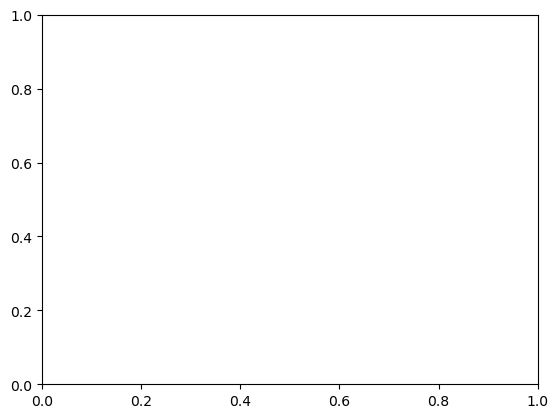

In [38]:
plt.plot([10,20,30,40,50,60,70,80,90,100,110,120],rmse_k)

In [45]:
preds=pd.DataFrame(predictions_k[0])

In [46]:
preds

,uid,iid,r_ui,est,details
0,1154117,CL0101EN,5.0,3.0,"{'actual_k': 40, 'was_impossible': False}"
1,1625978,DS0101EN,3.0,3.0,"{'actual_k': 40, 'was_impossible': False}"
2,1803217,DS0110EN,4.0,3.0,"{'actual_k': 40, 'was_impossible': False}"
3,670311,DV0151EN,3.0,3.0,"{'actual_k': 40, 'was_impossible': False}"
4,1073551,DS0101EN,3.0,3.0,"{'actual_k': 40, 'was_impossible': False}"
...,...,...,...,...,...
69987,1012991,DV0101EN,5.0,3.0,"{'actual_k': 40, 'was_impossible': False}"
69988,1061314,DS0101EN,4.0,3.0,"{'actual_k': 40, 'was_impossible': False}"
69989,747608,DV0101EN,3.0,3.0,"{'actual_k': 40, 'was_impossible': False}"
69990,676384,BD0115EN,4.0,3.0,"{'actual_k': 40, 'was_impossible': False}"


In [67]:
for i in range(len(preds)):
    if preds.details[i]['was_impossible']:#.str.find('True').unique():
        print(preds.iloc[i,:])

In [43]:
preds.uid.value_counts()

AttributeError: 'DataFrame' object has no attribute 'uid'

In [29]:
preds.r_ui.value_counts()

4.0    23458
3.0    23269
5.0    23265
Name: r_ui, dtype: int64

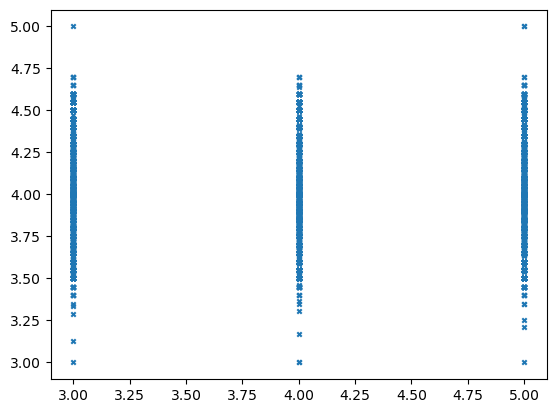

In [30]:

plt.scatter(preds['r_ui'],preds['est'],s=10,marker='x')

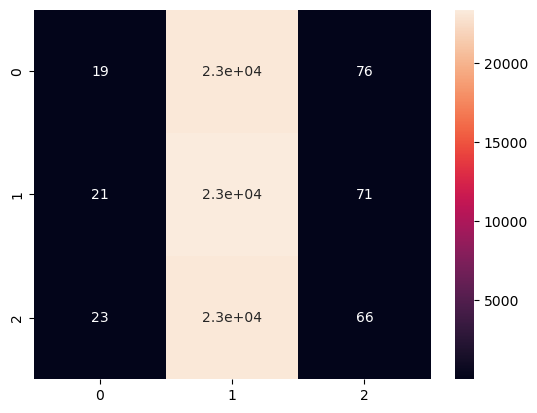

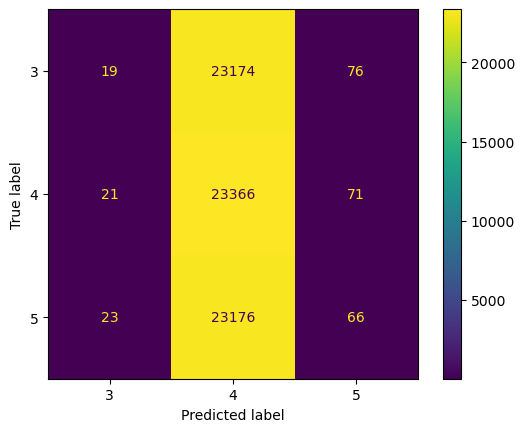

In [31]:

sns.heatmap(confusion_matrix(preds['r_ui'],preds['est'].map(np.round)),annot=True)

ConfusionMatrixDisplay.from_predictions(y_true=preds['r_ui'],y_pred=preds['est'].map(np.round),labels=[3,4,5])

In [ ]:
np.round(2.7)

3.0

In [ ]:
raw_ratings = course_dataset.raw_ratings

# A = 70% of the data, B = 30% of the data
threshold = int(0.7 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

course_dataset.raw_ratings = A_raw_ratings  # data is now the set A

# Select your best algo with grid search.
print("Grid Search...")
param_grid={
        'sim_option' : [
            {'name': 'cosine', 'user_based': False}],
        #    {'name': 'pearson', 'user_based': False},
        #    {'name': 'msd', 'user_based': False},
        #    {'name': 'cosine', 'user_based': True},
        #    {'name': 'pearson', 'user_based': True},
        #    {'name': 'msd', 'user_based': True}],
        'k':[10,50,100,200,300,500]
       }
grid_search = GridSearchCV(KNNBasic, param_grid, measures=["rmse"], cv=3)
grid_search.fit(course_dataset)

algo = grid_search.best_estimator["rmse"]

# retrain on the whole set A
trainset = course_dataset.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on A,", end="   ")
accuracy.rmse(predictions)

# Compute unbiased accuracy on B
testset = course_dataset.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print("Unbiased accuracy on B,", end=" ")
accuracy.rmse(predictions)

Grid Search...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix.

0.8192884236949356

In [ ]:
grid_search.best_params

{'rmse': {'k': 500}}

In [ ]:
results_df = pd.DataFrame.from_dict(grid_search.cv_results)

In [ ]:
results_df

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k
0,0.848477,0.851762,0.848219,0.849486,0.001613,6,14.050542,1.199451,26.294606,0.656065,{'k': 10},10
1,0.822110,0.825733,0.823628,0.823824,0.001486,5,13.109442,0.126473,27.402946,0.405226,{'k': 50},50
2,0.819208,0.823209,0.820462,0.820960,0.001671,4,12.894988,0.322712,29.699243,0.136412,{'k': 100},100
3,0.817562,0.822202,0.818993,0.819586,0.001940,3,13.035443,0.161393,33.360065,0.544610,{'k': 200},200
4,0.817179,0.821837,0.818618,0.819211,0.001947,2,12.655887,0.227898,34.358338,0.523418,{'k': 300},300
5,0.817025,0.821565,0.818351,0.818980,0.001906,1,12.741460,0.377485,37.968781,0.202483,{'k': 500},500


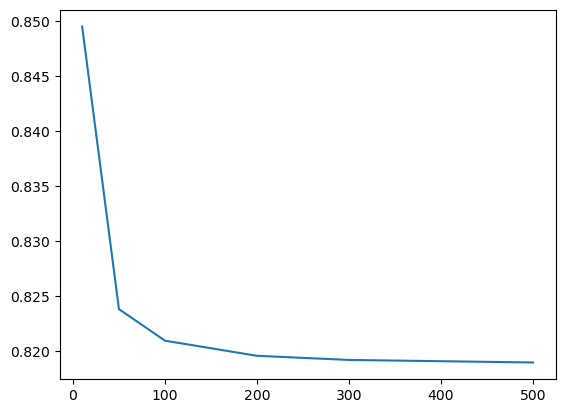

In [ ]:
plt.plot(results_df.param_k,results_df.mean_test_rmse)

In [ ]:
preds=pd.DataFrame(predictions)

In [ ]:
preds

,uid,iid,r_ui,est,details
0,511818,BD0111EN,4.0,4.008000,"{'actual_k': 500, 'was_impossible': False}"
1,935461,DS0101EN,4.0,3.968000,"{'actual_k': 500, 'was_impossible': False}"
2,1833633,ML0101ENv3,5.0,3.944444,"{'actual_k': 500, 'was_impossible': False}"
3,687233,ST0101EN,3.0,3.996755,"{'was_impossible': True, 'reason': 'User and/o..."
4,1586360,DV0101EN,5.0,3.996755,"{'was_impossible': True, 'reason': 'User and/o..."
...,...,...,...,...,...
48990,1492491,DS0103EN,3.0,4.069139,"{'actual_k': 437, 'was_impossible': False}"
48991,1006491,BD0111EN,5.0,3.992000,"{'actual_k': 500, 'was_impossible': False}"
48992,719864,CC0150EN,4.0,3.825385,"{'actual_k': 81, 'was_impossible': False}"
48993,989483,DA0101EN,5.0,4.022341,"{'actual_k': 500, 'was_impossible': False}"


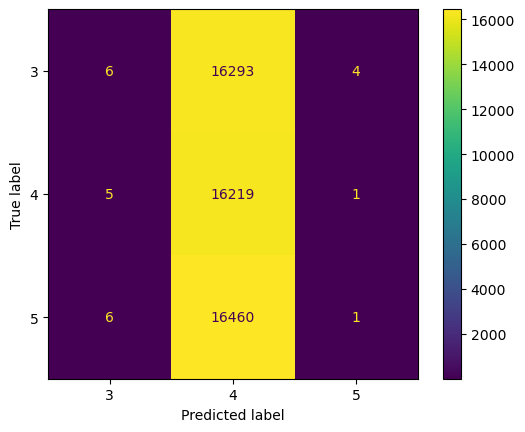

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true=preds['r_ui'],y_pred=preds['est'].map(np.round),labels=[3,4,5])

<details>
    <summary>Click here for Hints</summary>

* Create a model by calling `KNNBasic()` class. 
* Fit it with `trainset` by using `model.fit(trainset)`.  
* Record predictions to the `testset`  by using `model.test(testset).
* Compute the accuracy by using `accuracy.rmse(predictions)`


To learn more detailed usages about _Surprise_ library, visit its website from [here](https://surprise.readthedocs.io/en/stable/getting_started.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01)


## Implementation Option 2: Use `numpy`, `pandas`, and `sklearn`


If you do not prefer the one-stop Suprise solution and want more hardcore coding practices, you may implement the KNN model using `numpy`, `pandas`, and possibly `sklearn`:


In [ ]:
## WRITE YOUR CODE HERE:

## One solution could be:
## - Calculate the similarity between two users using their rating history (the row vectors of interaction matrix)
# surprise uses 3 similarity options: mean squared distance (MSD), cosine and Pearson.
## - Build a similarity matrix for each pair of users with the training dataset

## - For each user, find its k nearest neighbors in the sim matrix

## - For each rating in the test dataset, estimate its rating using the KNN collaborative filtering equations shown before

## - Calculate RMSE for the entire test dataset



## Summary



In this lab, you have learned and implemented KNN-based collaborative filtering. It is probably the simplest but very effective and intuitive collaborative filtering algorithm. Since it is based on KNN, it inherits the main characteristics of KNN such as memory-intensive because you need to maintain a huge similarity matrix among users or items. In the future labs, we will learn other types of collaborative filtering which do not rely on such a huge similarity matrix to make rating predictions.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


In [20]:
from surprise.dataset import DatasetAutoFolds

In [73]:
users=[]
courses=[]
scores=[]
res_dict={}

reader = Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(3, 5))
course_dataset = Dataset.load_from_file("ratings.csv", reader=reader)
trainset=DatasetAutoFolds.build_full_trainset(course_dataset)
model=KNNBasic(k=40)
model.fit(trainset)


ratings_df = pd.read_csv("ratings.csv")
course_genres_df = pd.read_csv("course_genres.csv")
user_ratings = ratings_df[ratings_df['user'] == 2]
enrolled_course_ids = user_ratings['item'].to_list()
all_courses = set(course_genres_df['COURSE_ID'].values)
unknown_courses = list(all_courses.difference(enrolled_course_ids))


#test_data=ratings_df[(ratings_df['item'].isin(unknown_courses))&(ratings_df['user']==2)]
test_data={}
test_data['user']=[2]*len(unknown_courses)
test_data['item']=unknown_courses
test_data['rating']=[4]*len(unknown_courses)
test_data=pd.DataFrame(test_data)

for i in range(test_data.shape[0]):
    result=model.predict(uid=test_data.loc[i,'user'],iid=test_data.loc[i,'item'],r_ui=test_data.loc[i,'rating'])
    users.append(int(result.uid))
    courses.append(result.iid)
    scores.append(float(result.est))
    
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
#res_df = res_df[res_df['SCORE']>=profile_sim_threshold].sort_values(by='SCORE',ascending=False)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [74]:
test_data

,user,item,rating
0,2,excourse26,4
1,2,CC0250EN,4
2,2,PA0109EN,4
3,2,PA0103EN,4
4,2,excourse73,4
...,...,...,...
241,2,DS0101EN,4
242,2,excourse42,4
243,2,excourse33,4
244,2,excourse17,4


In [29]:
ratings_df[(ratings_df['item'].isin(unknown_courses))]

,user,item,rating
0,1889878,CC0101EN,3.0
2,1990814,ML0120ENv3,3.0
4,779563,DS0101EN,3.0
7,1858700,CC0101EN,3.0
9,623377,DS0105EN,3.0
...,...,...,...
233350,2103055,excourse84,3.0
233360,2103061,excourse77,3.0
233361,2103062,excourse77,3.0
233362,2103063,excourse46,3.0


In [76]:
res_df.sort_values(by='SCORE',ascending=False)

,USER,COURSE_ID,SCORE
0,2,excourse26,3.0
154,2,CC0120EN,3.0
156,2,excourse02,3.0
157,2,GPXX05LMEN,3.0
158,2,GPXX0SDXEN,3.0
...,...,...,...
86,2,BD0115EN,3.0
87,2,excourse71,3.0
88,2,GPXX03HFEN,3.0
89,2,excourse78,3.0


```toggle## Change Log
```


```toggle|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
```
```toggle|-|-|-|-|
```
```toggle|2021-10-25|1.0|Yan|Created the initial version|
```
